# **I. Introduction**

Nama : Monica M. Pratiwi
<br>
Batch : FTDS-016-RMT





## **Query pada Google Cloud Platform**

Data yang digunakan adalah dataset `ml_datasets` dari database bernama `credit_card_default`.
<br>
Query yang dibuat memiliki kriteria sebagai berikut:
1. Kolom yang dipilih adalah `limit_balance`, `sex`, `education_level`, `marital_status`, `age`, `pay_0`, `pay_2`, `pay_3`, `pay_4`, `pay_5`, `pay_6`, `bill_amt_1`, `bill_amt_2`, `bill_amt_3`, `bill_amt_4`, `bill_amt_5`, `bill_amt_6`, `pay_amt_1`, `pay_amt_2`, `pay_amt_3`, `pay_amt_4`, `pay_amt_5`, `pay_amt_6`, `default_payment_next_month`.
2. Limit jumlah data menjadi sebanyak nomor batch dikali dengan tahun lahir. Untuk batch 16 dan lahir tahun 1998, maka nilai limit 16 x 1998 = 31968.

In [1]:
# Insert Query

#select * except(id, predicted_default_payment_next_month) from `bigquery-public-data.ml_datasets.credit_card_default`
#limit 31968;


## **Objective**

Membuat model Classification untuk memprediksi `default_payment_next_month` dengan beberapa model berbeda.

# **II. Import Libraries**

In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import array 
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, accuracy_score, f1_score

import joblib
import json
import warnings
warnings.filterwarnings("ignore")

# **III. Data Loading**

In [3]:
# Loading Dataset

data = pd.read_csv('/content/drive/MyDrive/bq-results-20221113-164523-1668357985841/h8dsft_P1M1_monica_pratiwi.csv')
data.head(2)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,130000,1,1,1,45,0,0,0,0,0,...,62377,63832,65099,2886,2908,2129,2354,2366,2291,0
1,230000,1,2,1,41,0,0,0,0,0,...,216260,215968,174195,9405,7769,7757,8030,6549,5226,1


In [4]:
# Show the first two rows of the unseen columns
data.iloc[:2, 10:15] 

,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4
0,0,58180,59134,61156,62377
1,0,301038,305327,213058,216260


In [5]:
# Make a copy
data_2=data.copy()

Setelah dilakukan loading dataset dari Big Query yang telah disimpan di Google Drive, data disalin agar memiliki cadangan. Selanjutnya, dilakukan pengecekan sederhana kolom-kolom yang ada pada dataset. Berikut keterangan dari kolom-kolom pada tabel.

Header | Notes
---|---
`limit_balance` | Amount of the given credit (NT dollar): it includes both the  individual consumer credit and his/her family (supplementary) credit.
`sex` | (1 = male; 2 = female).
`education_level` | (1 = graduate school; 2 = university; 3 = high school; 0, 4, 5, 6 = others).
`marital_status` | (1 = married; 2 = single; 3 = divorce; 0=others).
`age (year)`.
`pay_0` to `pay_6` | History of past payment from September to April 2005. (-2 = No consumption; -1 = Paid in full; 0 = The use of revolving credit; <br> 1 = payment delay for one month; 2 = payment delay for two months; . . . ; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
`bill_amt_1` to `bill_amt_6` (NT dollar) | amount of bill statement from September to April 2005;
`pay_amt_1` to `pay_amt_6` | Amount of previous payment (NT dollar) from September to April 2005
`default_payment_next_month` | (0 = not default; 1 = default)
<br>

In [6]:
data.describe()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
count,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,...,2965.000000,2965.000000,2965.000000,2965.000000,2.965000e+03,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000
mean,163369.308600,1.607757,1.849578,1.559865,35.193255,0.005059,-0.122428,-0.141653,-0.185160,-0.225295,...,44089.683305,40956.080607,39773.072513,6348.902867,6.272494e+03,5150.497133,4561.376054,4913.286678,5382.701518,0.214165
std,125030.415472,0.488333,0.778184,0.522317,9.109439,1.114395,1.180784,1.183630,1.178322,1.159003,...,61907.454056,58271.904751,57303.488981,20885.735336,2.887967e+04,14287.079982,13281.499599,16734.340778,17275.953029,0.410311
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2582.000000,1958.000000,1430.000000,1013.000000,9.900000e+02,477.000000,313.000000,323.000000,173.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19894.000000,18814.000000,18508.000000,2234.000000,2.175000e+03,1994.000000,1600.000000,1646.000000,1615.000000,0.000000
75%,230000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58622.000000,53373.000000,52287.000000,5087.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4081.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,69.000000,8.000000,7.000000,7.000000,8.000000,7.000000,...,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000,1.000000


In [7]:
data.iloc[:, 10:15].describe()

,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4
count,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000
mean,-0.254637,52118.305228,50649.153120,48239.757504,44089.683305
std,1.167305,72328.670541,70785.001588,68145.710745,61907.454056
min,-2.000000,-11545.000000,-67526.000000,-25443.000000,-46627.000000
25%,-1.000000,3958.000000,3390.000000,3302.000000,2582.000000
50%,0.000000,24257.000000,23111.000000,21520.000000,19894.000000
75%,0.000000,69852.000000,67827.000000,63023.000000,58622.000000
max,7.000000,613860.000000,512650.000000,578971.000000,488808.000000


Ringkasan data menunjukkan rata-rata pengguna kartu kredit berusia sekitar 35 tahun. Sebaran data usia sangat beragam antara 21 hingga 69 tahun. rata-rata limit balance sepanjang April hingga September 2005 adalah sekitar 163000 dengan rata-rata tagihan per bulannya berkisar antara 39000 hingga 53000. Namun rata-rata jumlah yang dibayarkan setiap bulannya adalah sekitar 5300-6400. Artinya rata-rata pengguna menggunakan revolving credit. Dengan tagihan terbesar yang tercatat mencapai 613860 dan pembayaran tagihan yang terbesar sebanyak 493358, artinya tersisa tagihan senilai 120000 yang tidak dapat terbayarkan oleh pengguna.
<br>
<br>
Dari kolom ini outlier juga sekilas dapat diamati. Nilai mean sensitif terhadap outlier. Pada kolom `limit_balance`, nilai mean nilai yang jauh dari nilai maksimum (max), mengindikasikan bahwa nilai maksimum adalah outlier. Hal yang sama juga terjadi `bill_amt_1`,`bill_amt_2`,	`bill_amt_3`,	`bill_amt_4`, `bill_amt_5`, `bill_amt_6`, `pay_amt_1`,	`pay_amt_2`,	`pay_amt_3`,	`pay_amt_4`,	`pay_amt_5`,	`pay_amt_6`.  

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   limit_balance               2965 non-null   int64
 1   sex                         2965 non-null   int64
 2   education_level             2965 non-null   int64
 3   marital_status              2965 non-null   int64
 4   age                         2965 non-null   int64
 5   pay_0                       2965 non-null   int64
 6   pay_2                       2965 non-null   int64
 7   pay_3                       2965 non-null   int64
 8   pay_4                       2965 non-null   int64
 9   pay_5                       2965 non-null   int64
 10  pay_6                       2965 non-null   int64
 11  bill_amt_1                  2965 non-null   int64
 12  bill_amt_2                  2965 non-null   int64
 13  bill_amt_3                  2965 non-null   int64
 14  bill_amt

Berdasarkan informasi data, terdapat 24 kolom pada data dan seluruhnya memiliki tipe data integer. Berdasarkan informasi pada keterangan isi tabel, data `sex`, `education level`, `marital status`, dan `default payment next month` sebenarnya adalah data kategori yang nilainya dapat diwakili dengan angka. Jumlah baris pada data tersebut adalah 2965. Tidak terdeteksi adanya missing value pada data. 
<br>
<br>
Agar proses analisis data dapat berjalan lebih baik, dilakukan perubahan nama kolom yang hasilnya adalah sebagai berikut.

In [9]:
# Rename columns
data.rename({"pay_0": "stat_1", "pay_2": "stat_2", "pay_3": "stat_3", "pay_4": "stat_4", "pay_5": "stat_5","pay_6": "stat_6"}, axis=1, inplace=True)
data.head()

,limit_balance,sex,education_level,marital_status,age,stat_1,stat_2,stat_3,stat_4,stat_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,130000,1,1,1,45,0,0,0,0,0,...,62377,63832,65099,2886,2908,2129,2354,2366,2291,0
1,230000,1,2,1,41,0,0,0,0,0,...,216260,215968,174195,9405,7769,7757,8030,6549,5226,1
2,50000,1,2,1,42,0,0,0,0,0,...,31320,36227,35569,2007,2000,1500,5400,0,3000,0
3,200000,1,1,1,58,0,0,0,0,0,...,124647,126921,129167,7822,4417,4446,4597,4677,4698,0
4,500000,1,1,1,39,0,0,0,0,0,...,174500,137406,204975,54209,4607,4603,5224,207440,7509,0


In [10]:
data.iloc[:5, 10:15] 

,stat_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4
0,0,58180,59134,61156,62377
1,0,301038,305327,213058,216260
2,2,35892,32546,30660,31320
3,0,192461,195970,122214,124647
4,0,133598,167378,171106,174500


# **IV. Exploratory Data Analysis**

In [11]:
# Number of people with and without default payment
data["default_payment_next_month"].value_counts()

0    2330
1     635
Name: default_payment_next_month, dtype: int64

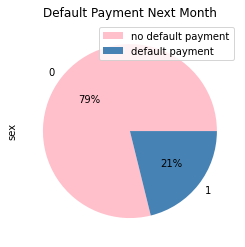

In [12]:
# Plotting number of people with and without default payment on piechart
data.groupby(['default_payment_next_month']).sum().plot(kind='pie', y='sex', autopct='%1.0f%%', colors = ['pink', 'steelblue'],
                                title='Default Payment Next Month')
plt.legend(["no default payment", "default payment"])

Melalui query sederhana, dapat diketahui sebanyak 2330 pengguna tidak memiliki default payment dan 635 pengguna (21% dari keseluruhan pengguna) memiliki default payment. Pengguna dengan tidak memiliki `default_payment_next_month` mengindikasikan adanya riwayat kredit yang tergolong baik. Tagihan yang masuk masih berada dalam jumlah yang masih bisa dibayarkan.

Tidak ada indikator lain yang dapat digunakan sebagai pertimbangan dalam menentukan default payment seperti waktu pembayaran yang dapat menunjukkan apakah seluruh pengguna membayar tagihannya tepat waktu. 

Meskipun jumlah pengguna yang memiliki default payment lebih sedikit, jumlahnya yang mencapai 21% dari keseluruhan pengguna perlu diwaspadai. Adapun secara keseluruhan proporsi antara default payment dan no default payment dapat dikatakan tidak simbang.



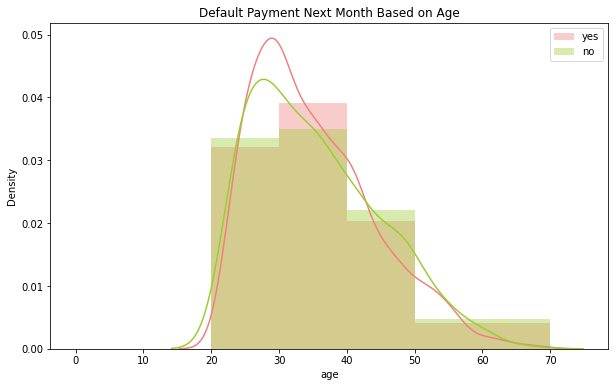

In [13]:
# Plotting Number of people with and without default payment based on age
plt.figure(figsize=(10,6))
sns.distplot(data.age[data.default_payment_next_month == 0], bins=[0, 20, 30, 40, 50, 70], color='lightcoral', label='yes')
sns.distplot(data.age[data.default_payment_next_month == 1], bins=[0, 20, 30, 40, 50,70], color='yellowgreen', label='no')
plt.title('Default Payment Next Month Based on Age')
plt.legend()

Berdasarkan gambar, informasi yang dapat kita peroleh adalah kelompok usia 35-40 tahun cenderung lebih banyak mengalami default payment. Kelompok usia tersebut biasanya sudah memiliki pekerjaan yang ditekuni. Penghasilan yang diperoleh dapat digunakan untuk membayar tagihan kartu kredit. 

In [14]:
# Correlation Test between Age, Marital Status, and Education Level with Limit Balance and Default Payment
corr=data.corr().loc[['age', 'sex', 'marital_status', 'education_level', 'limit_balance'], ['limit_balance', 'default_payment_next_month']]

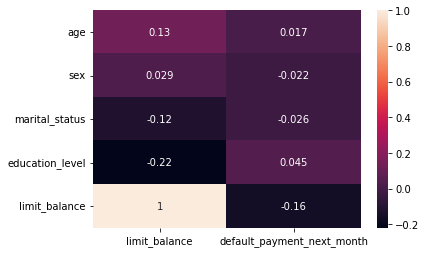

In [15]:
sns.heatmap(corr, annot=True)

Untuk melihat apakah terdapat hubungan antara usia dan default payment, uji korelasi dilakukan.  Meskipun pada grafik 'Default Payment Next Month Based on Age' menunjukkan kelompok tertentu cenderung mengalami default payment, korelasi antara usia dengan default payment berbanding lurus dan cenderung lemah. Artinya tidak ada hubungan yang signifikan antara usia dengan default payment. Begitupun dengan tingkat pendidikan. Meskipun nilai korelasinya tampak lebih besar, namun tidak cukup untuk membuktikan adanya hubungan yang signifikan antara tingkat pendidikan dan default payment. Status pernikahan memiliki hubungan yang berbanding terbalik dan lemah. Artinya pengguna yang menikah cenderung mengalami default payment daripada yang single atau bercerai. Namun hubungan antara keduanya lemah.
<br>
<br>
Default payment dapat terjadi karena berbagai hal, salah satunya adalah perilaku penggunaan kartu kredit yang kurang berhati-hati. Hasil penelitian Memarista, et al (2015) yang meneliti perilaku penggunaan kartu kredit di Surabaya menunjukkan bahwa pendidikan memiliki hubungan yang signifikan dengan perilaku penggunaan kartu kredit sementara usia, jenis kelamin, pendapatan, dan status perkawinan tidak memiliki hubungan yang signifikan terhadap penggunaan kartu kredit.
<br>
<br>
Hubungan antara usia dan limit yang ditetapkan juga cenderung tidak signifikan, begitupun dengan marital status dan education level terhadap limit balance yang korelasinya berbanding terbalik namun lemah.



# **V. Data Preprocessing**

In [16]:
# Get data for model inference

data_inference = data.sample(15, random_state=198)

In [17]:
# Remove inference set from dataset

data_train_test = data.drop(data_inference.index)

In [18]:
# Reset Index

data_train_test.reset_index(drop=True, inplace=True)
data_inference.reset_index(drop=True, inplace=True)

## **Splitting Between X (Feature) and y (Target)**

In [19]:
# Splitting between `X ` AND `y`

X = data_train_test.drop(['default_payment_next_month'], axis=1) 
y = data_train_test['default_payment_next_month']
X.head()

,limit_balance,sex,education_level,marital_status,age,stat_1,stat_2,stat_3,stat_4,stat_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,130000,1,1,1,45,0,0,0,0,0,...,61156,62377,63832,65099,2886,2908,2129,2354,2366,2291
1,230000,1,2,1,41,0,0,0,0,0,...,213058,216260,215968,174195,9405,7769,7757,8030,6549,5226
2,50000,1,2,1,42,0,0,0,0,0,...,30660,31320,36227,35569,2007,2000,1500,5400,0,3000
3,200000,1,1,1,58,0,0,0,0,0,...,122214,124647,126921,129167,7822,4417,4446,4597,4677,4698
4,500000,1,1,1,39,0,0,0,0,0,...,171106,174500,137406,204975,54209,4607,4603,5224,207440,7509


In [20]:
# Splitting between Train-Set dengan Test-Set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=52)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (2360, 23)
Test Size:  (590, 23)


In [21]:
X_train.describe()

,limit_balance,sex,education_level,marital_status,age,stat_1,stat_2,stat_3,stat_4,stat_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
count,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.00000,2360.000000,2360.000000,2360.000000,2360.000000,...,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2.360000e+03,2360.000000,2360.000000,2360.000000,2360.000000
mean,163677.966102,1.600847,1.848729,1.557203,35.150424,0.00678,-0.111441,-0.147458,-0.193220,-0.221610,...,47768.555508,44079.531356,41080.020763,39984.948305,6469.749576,6.398604e+03,5276.314407,4447.132203,4970.238559,5300.060593
std,124049.374228,0.489828,0.776126,0.524224,9.029451,1.12543,1.190910,1.183589,1.173736,1.150612,...,66809.138745,61543.553759,57758.881962,57269.799524,21292.397842,3.159172e+04,14722.150835,12593.674881,17604.939890,16141.246256
min,10000.000000,1.000000,1.000000,0.000000,21.000000,-2.00000,-2.000000,-2.000000,-2.000000,-2.000000,...,-25443.000000,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,...,3232.000000,2639.000000,2087.500000,1467.000000,1003.750000,8.950000e+02,470.750000,323.500000,379.250000,204.250000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,21062.000000,19861.000000,19031.500000,18581.500000,2310.000000,2.139500e+03,1909.500000,1638.500000,1632.500000,1674.000000
75%,230000.000000,2.000000,2.000000,2.000000,41.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,62966.500000,58496.750000,53609.250000,52297.000000,5089.500000,5.006250e+03,4573.000000,4000.000000,4000.000000,4012.000000
max,780000.000000,2.000000,6.000000,3.000000,69.000000,8.00000,7.000000,7.000000,8.000000,7.000000,...,559712.000000,485249.000000,441981.000000,424592.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,228300.000000


In [22]:
X_train.iloc[:5, 10:15].describe()

,stat_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.200000,95646.400000,94644.400000,72014.400000,51781.800000
std,1.095445,96318.337684,91005.305707,64969.502848,47121.668134
min,-1.000000,0.000000,1216.000000,2677.000000,2985.000000
25%,0.000000,35215.000000,36227.000000,37876.000000,18657.000000
50%,0.000000,50060.000000,54213.000000,49512.000000,39984.000000
75%,0.000000,165686.000000,169969.000000,99865.000000,77754.000000
max,2.000000,227271.000000,211597.000000,170142.000000,119529.000000


## **Outlier**

In [23]:
# Check Skewness
print('Skewness Value limit_balance : ', X_train['limit_balance'].skew())
print('Skewness Value bill_amt_1: ', X_train['bill_amt_1'].skew())
print('Skewness Value bill_amt_2: ', X_train['bill_amt_2'].skew())
print('Skewness Value bill_amt_3: ', X_train['bill_amt_3'].skew())
print('Skewness Value bill_amt_4: ', X_train['bill_amt_4'].skew())
print('Skewness Value bill_amt_5: ', X_train['bill_amt_5'].skew())
print('Skewness Value bill_amt_6: ', X_train['bill_amt_6'].skew())
print('Skewness Value pay_amt_1: ', X_train['pay_amt_1'].skew())
print('Skewness Value pay_amt_2: ', X_train['pay_amt_2'].skew())
print('Skewness Value pay_amt_3: ', X_train['pay_amt_3'].skew())
print('Skewness Value pay_amt_4: ', X_train['pay_amt_4'].skew())
print('Skewness Value pay_amt_5: ', X_train['pay_amt_5'].skew())
print('Skewness Value pay_amt_6: ', X_train['pay_amt_6'].skew())

Skewness Value limit_balance :  0.9555057590888052
Skewness Value bill_amt_1:  2.40563574787452
Skewness Value bill_amt_2:  2.401326920686698
Skewness Value bill_amt_3:  2.4495112524332736
Skewness Value bill_amt_4:  2.378342474801711
Skewness Value bill_amt_5:  2.3441670387273037
Skewness Value bill_amt_6:  2.382547304940993
Skewness Value pay_amt_1:  11.137329963057812
Skewness Value pay_amt_2:  28.079025287706976
Skewness Value pay_amt_3:  7.777819176684935
Skewness Value pay_amt_4:  8.85080619197179
Skewness Value pay_amt_5:  11.648806916913884
Skewness Value pay_amt_6:  7.700114415697569


Nilai kecondongan dapat mengindikasikan distribusi data yang tidak normal dan adanya outlier. Feature dengan nilai kecondongan tertinggi adalah `pay_amt_2` dengan 29,79. Untuk mengetahui jumlah outlier pada setiap feature dilakukan dengan metode IQR (Inter Quartile Range).

In [24]:
# Create a function to find outliers using IQR

def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [25]:
# Find Outlier 
outliers = find_outliers_IQR(X_train["limit_balance"])
print("number of outliers limit_balance: "+ str(len(outliers)))
outliers = find_outliers_IQR(X_train["bill_amt_1"])
print("number of outliers bill_amt_1: "+ str(len(outliers)))
outliers = find_outliers_IQR(data["bill_amt_2"])
print("number of outliers bill_amt_2: "+ str(len(outliers)))
outliers = find_outliers_IQR(data["bill_amt_3"])
print("number of outliers bill_amt_3: "+ str(len(outliers)))
outliers = find_outliers_IQR(data["bill_amt_4"])
print("number of outliers bill_amt_4: "+ str(len(outliers)))
outliers = find_outliers_IQR(data["bill_amt_5"])
print("number of outliers bill_amt_5: "+ str(len(outliers)))
outliers = find_outliers_IQR(data["bill_amt_6"])
print("number of outliers bill_amt_6: "+ str(len(outliers)))
outliers = find_outliers_IQR(data["pay_amt_1"])
print("number of outliers pay_amt_1: "+ str(len(outliers)))
outliers = find_outliers_IQR(data["pay_amt_2"])
print("number of outliers pay_amt_2: "+ str(len(outliers)))
outliers = find_outliers_IQR(data["pay_amt_3"])
print("number of outliers pay_amt_3: "+ str(len(outliers)))
outliers = find_outliers_IQR(data["pay_amt_4"])
print("number of outliers pay_amt_4: "+ str(len(outliers)))
outliers = find_outliers_IQR(data["pay_amt_5"])
print("number of outliers pay_amt_5: "+ str(len(outliers)))
outliers = find_outliers_IQR(data["pay_amt_6"])
print("number of outliers pay_amt_6: "+ str(len(outliers)))

number of outliers limit_balance: 11
number of outliers bill_amt_1: 172
number of outliers bill_amt_2: 227
number of outliers bill_amt_3: 230
number of outliers bill_amt_4: 208
number of outliers bill_amt_5: 238
number of outliers bill_amt_6: 232
number of outliers pay_amt_1: 276
number of outliers pay_amt_2: 287
number of outliers pay_amt_3: 266
number of outliers pay_amt_4: 275
number of outliers pay_amt_5: 284
number of outliers pay_amt_6: 298


Jumlah outlier yang banyak dan data yang sedikit membuat outlier tidak mungkin untuk dihapus. Melakukan treatment seperti trimming dan Winsorizer tidak disarankan untuk data-data finansial (Adams, et al., 2019). Metode yang disarankan untuk dilakukan dalam treatment outliers adalah menggunakan log data, quantile regression, dan Bayesian solution (Moritz B, 2018). Diputuskan untuk tidak melakukan apapun untuk menangani outliers dalam data ini.

## **Missing Values**

In [26]:
# Find missing values on `X_train`
X_train.isna().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
stat_1             0
stat_2             0
stat_3             0
stat_4             0
stat_5             0
stat_6             0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [27]:
# Find missing values on `X_test`
X_test.isna().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
stat_1             0
stat_2             0
stat_3             0
stat_4             0
stat_5             0
stat_6             0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [28]:
# Find missing values on `y_train`
y_train.isna().sum()

0

In [29]:
# Find missing values on `y_train`
y_test.isna().sum()

0

Tidak ditemukan missing values maupun nilai mencurigakan lainnya pada data.

## **Feature Scaling**

In [48]:
# Define column
numerical = X_train.select_dtypes(include=np.number).columns.tolist()
X_train_num = X_train[numerical]
X_test_num = X_test[numerical]
X_train_num.head(5)

,limit_balance,sex,education_level,marital_status,age,stat_1,stat_2,stat_3,stat_4,stat_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
1389,210000,2,2,2,41,0,0,0,0,0,...,99865,77754,49529,30683,9000,4000,3018,2000,3000,3000
786,260000,2,2,1,42,0,0,0,0,0,...,49512,18657,33296,32622,5000,2655,800,15000,0,10000
678,160000,2,2,1,42,0,0,0,0,0,...,170142,119529,122059,111378,8450,5289,4022,4195,3986,3958
2801,140000,2,1,2,29,1,-1,-1,-1,-1,...,2677,2985,3739,1242,1216,2698,6069,3889,1242,3061
1733,50000,1,1,2,27,0,0,0,2,2,...,37876,39984,39041,40110,1600,2234,3042,0,1700,2000


In [53]:
# Feature Scaling
num_pipeline = Pipeline([
        ('scaler', MinMaxScaler())
    ])

num_tr = num_pipeline.fit_transform(X_train_num)
test_tr = num_pipeline.transform(X_test_num)
num_tr

array([[0.25974026, 1.        , 0.2       , ..., 0.00989727, 0.00773054,
        0.0131406 ],
       [0.32467532, 1.        , 0.2       , ..., 0.0742295 , 0.        ,
        0.04380201],
       [0.19480519, 1.        , 0.2       , ..., 0.02075952, 0.01027132,
        0.01733684],
       ...,
       [0.32467532, 1.        , 0.2       , ..., 0.        , 0.        ,
        0.        ],
       [0.25974026, 1.        , 0.        , ..., 0.01776559, 0.00983068,
        0.01697766],
       [0.24675325, 1.        , 0.        , ..., 0.03929215, 0.01806113,
        0.03066141]])

Pemilihan MinMaxScaler digunakan dengan pertimbangan feature yang tidak terdistribusi dengan normal, walaupun metode ini sensitif terhadap outlier dan tidak ada handling outlier yang dilakukan.

# **VI. Cross Validation Between Models**

In [54]:
# Build Model
logreg = LogisticRegression(max_iter=1000000)
svm = SVC(random_state=92)
dtc = DecisionTreeClassifier(random_state=77)
rfc = RandomForestClassifier(random_state=55)
etc = ExtraTreesClassifier(random_state=101)
knn = KNeighborsClassifier()
gnb = GaussianNB()

In [ ]:
# Train model Logistic Regression
logreg.fit(num_tr, y_train)

In [55]:
# Predict Model Logistic Regression
X_train_logreg = logreg.predict(num_tr)
X_test_logreg = logreg.predict(test_tr)

print(classification_report(y_train, X_train_logreg))
print(classification_report(y_test, X_test_logreg))

              precision    recall  f1-score   support

           0       0.83      0.98      0.89      1853
           1       0.74      0.25      0.37       507

    accuracy                           0.82      2360
   macro avg       0.78      0.61      0.63      2360
weighted avg       0.81      0.82      0.78      2360

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       463
           1       0.79      0.20      0.33       127

    accuracy                           0.82       590
   macro avg       0.80      0.59      0.61       590
weighted avg       0.81      0.82      0.77       590



Logistic Regression merupakan algoritma Machine Learning yang sensitif terhadap oulier dan termasuk ke dalam model linear. Berdasarkan hasil prediksi model di atas, model cenderung dapat memprediksi dengan baik terutama untuk kelas yang tidak mengalami default payment.  Model tampak tidak dapat memprediksi pengguna yang akan mengalami kegagalan pembayaran, ditunjukkan dengan nilai recall yang sangat rendah bahkan kurang dari 50 persen.

In [ ]:
# Train model SVM
svm.fit(num_tr, y_train)

In [59]:
# Predict Model SVM
X_train_svm = svm.predict(num_tr)
X_test_svm = svm.predict(test_tr)

print(classification_report(y_train, X_train_svm))
print(classification_report(y_test, X_test_svm))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1853
           1       0.76      0.34      0.47       507

    accuracy                           0.83      2360
   macro avg       0.80      0.65      0.69      2360
weighted avg       0.82      0.83      0.81      2360

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       463
           1       0.74      0.27      0.39       127

    accuracy                           0.82       590
   macro avg       0.78      0.62      0.64       590
weighted avg       0.81      0.82      0.79       590



Model SVM memiliki permasalahan serupa dengan Regresi logistik. Dalam meprediksi pengguna yang tidak mengalami default payment, model ini sedikit lebih baik jika melihat berdasarkan nilai f1-score nya. Namun untuk kelas yang lainnya, model ini tidak dapat memprediksinya dengan baik

In [ ]:
# Train model Decision Tree Classifier
dtc.fit(num_tr, y_train)

In [60]:
# Predict Model Decision Tree Classifier
X_train_dtc = dtc.predict(num_tr)
X_test_dtc = dtc.predict(test_tr)

print(classification_report(y_train, X_train_dtc))
print(classification_report(y_test, X_test_dtc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1853
           1       1.00      1.00      1.00       507

    accuracy                           1.00      2360
   macro avg       1.00      1.00      1.00      2360
weighted avg       1.00      1.00      1.00      2360

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       463
           1       0.29      0.28      0.29       127

    accuracy                           0.70       590
   macro avg       0.55      0.55      0.55       590
weighted avg       0.69      0.70      0.70       590



In [85]:
# Train model Random Forest Classifier
rfc.fit(num_tr, y_train)

RandomForestClassifier(random_state=0)

In [86]:
# Predict Model Random Forest Classifier
X_train_rfc = rfc.predict(num_tr)
X_test_rfc = rfc.predict(test_tr)

print(classification_report(y_train, X_train_rfc))
print(classification_report(y_test, X_test_rfc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1853
           1       1.00      1.00      1.00       507

    accuracy                           1.00      2360
   macro avg       1.00      1.00      1.00      2360
weighted avg       1.00      1.00      1.00      2360

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       463
           1       0.71      0.35      0.47       127

    accuracy                           0.83       590
   macro avg       0.78      0.65      0.68       590
weighted avg       0.81      0.83      0.80       590



In [ ]:
# Train model Extra Trees Classifier
etc.fit(num_tr, y_train)

In [62]:
#Predict Model Extra Tree Classifier
X_train_etc = etc.predict(num_tr)
X_test_etc = etc.predict(test_tr)

print(classification_report(y_train, X_train_etc))
print(classification_report(y_test, X_test_etc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1853
           1       1.00      1.00      1.00       507

    accuracy                           1.00      2360
   macro avg       1.00      1.00      1.00      2360
weighted avg       1.00      1.00      1.00      2360

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       463
           1       0.67      0.35      0.46       127

    accuracy                           0.82       590
   macro avg       0.75      0.65      0.67       590
weighted avg       0.80      0.82      0.80       590



In [ ]:
# Train model KNN
knn.fit(num_tr, y_train)

In [63]:
# Predict Model KNN
X_train_knn = knn.predict(num_tr)
X_test_knn = knn.predict(test_tr)

print(classification_report(y_train, X_train_knn))
print(classification_report(y_test, X_test_knn))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1853
           1       0.74      0.43      0.55       507

    accuracy                           0.85      2360
   macro avg       0.80      0.70      0.73      2360
weighted avg       0.84      0.85      0.83      2360

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       463
           1       0.66      0.33      0.44       127

    accuracy                           0.82       590
   macro avg       0.75      0.64      0.67       590
weighted avg       0.80      0.82      0.79       590



In [ ]:
# Train model Naive Bayes
gnb.fit(num_tr, y_train)

In [64]:
# Predict Model Naive Bayes
X_train_gnb = gnb.predict(num_tr)
X_test_gnb = gnb.predict(test_tr)

print(classification_report(y_train, X_train_gnb))
print(classification_report(y_test, X_test_gnb))

              precision    recall  f1-score   support

           0       0.92      0.28      0.43      1853
           1       0.26      0.91      0.40       507

    accuracy                           0.42      2360
   macro avg       0.59      0.60      0.41      2360
weighted avg       0.78      0.42      0.42      2360

              precision    recall  f1-score   support

           0       0.87      0.29      0.43       463
           1       0.25      0.84      0.38       127

    accuracy                           0.41       590
   macro avg       0.56      0.57      0.41       590
weighted avg       0.74      0.41      0.42       590



In [65]:
# Checking cross validation score
kf = KFold(shuffle=True, n_splits=5)
cv_logreg = cross_val_score(logreg, num_tr, y_train, cv=kf, scoring="f1")
cv_svm = cross_val_score(svm, num_tr, y_train, cv=kf, scoring="f1")
cv_dtc = cross_val_score(dtc, num_tr, y_train, cv=kf, scoring="f1")
cv_rfc = cross_val_score(rfc, num_tr, y_train, cv=kf, scoring="f1")
cv_knn = cross_val_score(knn, num_tr, y_train, cv=kf, scoring="f1")
cv_gnb = cross_val_score(gnb, num_tr, y_train, cv=kf, scoring="f1")
cv_etc = cross_val_score(etc, num_tr, y_train, cv=kf, scoring="f1")
name_model = []
cv_scores=0
for cv,name in zip([cv_logreg,cv_svm,cv_dtc,cv_rfc,cv_knn,cv_gnb,cv_etc],['logreg_model','svm_model','dtc_model','rfc_model','knn_model','gnb_model','etc_model']):
    print(name)
    print('f1 score - All - Cross Validation  : ', cv)
    print('f1 score - Mean - Cross Validation : ', cv.mean())
    print('f1 score - Std - Cross Validation  : ', cv.std())
    print('f1 score - Range of Test-Set       : ', (cv.mean()-cv.std()) , '-', (cv.mean()+cv.std()))
    print('-'*50)
    if cv.mean()>cv_scores:
        cv_scores = cv.mean()
        name_model = name
    else:
        pass
print('best model:', name_model)
print('cross-val mean:', cv_scores)

logreg_model
f1 score - All - Cross Validation  :  [0.34042553 0.288      0.38297872 0.34645669 0.31147541]
f1 score - Mean - Cross Validation :  0.33386727161372004
f1 score - Std - Cross Validation  :  0.03230678282642469
f1 score - Range of Test-Set       :  0.30156048878729536 - 0.3661740544401447
--------------------------------------------------
svm_model
f1 score - All - Cross Validation  :  [0.46052632 0.41666667 0.44444444 0.35714286 0.4028777 ]
f1 score - Mean - Cross Validation :  0.4163315963770337
f1 score - Std - Cross Validation  :  0.03585507484425126
f1 score - Range of Test-Set       :  0.38047652153278244 - 0.452186671221285
--------------------------------------------------
dtc_model
f1 score - All - Cross Validation  :  [0.36936937 0.39269406 0.44748858 0.33507853 0.33962264]
f1 score - Mean - Cross Validation :  0.3768506386624087
f1 score - Std - Cross Validation  :  0.041054927597741375
f1 score - Range of Test-Set       :  0.3357957110646673 - 0.417905566260150

Berdasarkan perbandingan nilai cross validation antara 7 model, dapat terlihat bahwa penggunaan model Random Forest Classifier menghasilkan nilai rata-rata tertinggi dan standar deviasi terendah. Nilai standar deviasi rendah menunjukan data-data berkumpul di sekitar mean sehingga data menjadi lebih baik.

# **VII. Model Improvement (Hyperparameter Tuning : Grid Search)**

In [67]:
# Train with Grid Search

%%time
params = [
    {'n_estimators': [10, 20, 40, 60],        
     'max_features': [2, 3, 5, 1],            
     'max_depth': [5, 10, None],              
     'criterion': ['gini', 'entropy']},       
  ]

rfc = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(rfc, params, cv=5,
                           scoring='f1',
                           return_train_score=True)
grid_search.fit(num_tr, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [5, 10, None],
                          'max_features': [2, 3, 5, 1],
                          'n_estimators': [10, 20, 40, 60]}],
             return_train_score=True, scoring='f1')

In [69]:
# Get Best Hyperparameters

grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 3, 'n_estimators': 10}

In [70]:
grid_search.best_score_

0.49484698692726575

In [71]:
# Get Best Estimator

model = grid_search.best_estimator_

model.fit(num_tr, y_train)

model_train = model.predict(num_tr)
model_test = model.predict(test_tr)

print(classification_report(y_train, model_train))
print(classification_report(y_test, model_test))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1853
           1       0.81      0.40      0.53       507

    accuracy                           0.85      2360
   macro avg       0.83      0.69      0.72      2360
weighted avg       0.85      0.85      0.83      2360

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       463
           1       0.73      0.29      0.42       127

    accuracy                           0.82       590
   macro avg       0.78      0.63      0.66       590
weighted avg       0.81      0.82      0.79       590



Setelah melakukan tuning hyperparameter, model dengan data latihan menjadi kurang akurat untuk memprediksi pengguna yang tidak mengalami default payment dan meningkat dengan data test. Sayangnya, kemampuan model untuk memprediksi pengguna yang mengalami kegagalan pembayaran semakin menurun.

# **X. Model Inference**

In [87]:
# Save the Files

import joblib
import json

with open('model_rfc.pkl', 'wb') as file_1:
  joblib.dump(rfc, file_1)

with open('model_pipeline.pkl', 'wb') as file_2:
  joblib.dump(num_pipeline, file_2)

with open('list_num_cols.txt', 'w') as file_3:
  json.dump(numerical, file_3)


In [88]:
# Load All Files

import joblib
import json

with open('model_rfc.pkl', 'rb') as file_1:
  rfc = joblib.load(file_1)

with open('model_pipeline.pkl', 'rb') as file_2:
 num_pipeline = joblib.load(file_2)

with open('list_num_cols.txt', 'r') as file_3:
  numerical = json.load(file_3)


In [89]:
data_inference.head()

,limit_balance,sex,education_level,marital_status,age,stat_1,stat_2,stat_3,stat_4,stat_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,180000,2,1,2,28,1,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
1,280000,2,2,2,29,-1,-1,-1,-1,-1,...,2287,10969,5395,3419,8283,2287,10969,0,0,0
2,310000,2,2,1,35,2,0,0,0,0,...,258610,246491,198889,13019,11128,8407,8599,6833,5987,1
3,280000,2,2,2,43,0,0,0,0,0,...,33350,34047,34525,1527,1541,1192,1233,1239,1273,0
4,310000,1,1,1,45,-2,-2,-2,-2,-2,...,-16,-16,-16,1174,6527,0,0,0,0,0


In [90]:
# Split between Numerical Columns

data_inf_num = data_inference[numerical]
data_inf_num.head()

,limit_balance,sex,education_level,marital_status,age,stat_1,stat_2,stat_3,stat_4,stat_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,180000,2,1,2,28,1,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
1,280000,2,2,2,29,-1,-1,-1,-1,-1,...,8220,2287,10969,5395,3419,8283,2287,10969,0,0
2,310000,2,2,1,35,2,0,0,0,0,...,306314,258610,246491,198889,13019,11128,8407,8599,6833,5987
3,280000,2,2,2,43,0,0,0,0,0,...,32897,33350,34047,34525,1527,1541,1192,1233,1239,1273
4,310000,1,1,1,45,-2,-2,-2,-2,-2,...,6495,-16,-16,-16,1174,6527,0,0,0,0


In [ ]:
# Feature Scaling and Feature Encoding

data_inf_num_scaled = num_pipeline.transform(data_inf_num)
data_inf_num_scaled

In [93]:
# Predict using Random Forest Classifier

y_pred_inf = rfc.predict(data_inf_num_scaled)
y_pred_inf

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [94]:
# Create DataFrame

y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['Pred_default_payment_next_month'])
y_pred_inf_df.head()

,Pred_default_payment_next_month
0,0
1,0
2,1
3,0
4,0


In [96]:
# Concate between Inference-Set and Rating's Prediction

fin = pd.concat([data_inference, y_pred_inf_df], axis=1)
fin

,limit_balance,sex,education_level,marital_status,age,stat_1,stat_2,stat_3,stat_4,stat_5,...,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month,Pred_default_payment_next_month
0,180000,2,1,2,28,1,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
1,280000,2,2,2,29,-1,-1,-1,-1,-1,...,10969,5395,3419,8283,2287,10969,0,0,0,0
2,310000,2,2,1,35,2,0,0,0,0,...,246491,198889,13019,11128,8407,8599,6833,5987,1,1
3,280000,2,2,2,43,0,0,0,0,0,...,34047,34525,1527,1541,1192,1233,1239,1273,0,0
4,310000,1,1,1,45,-2,-2,-2,-2,-2,...,-16,-16,1174,6527,0,0,0,0,0,0
5,200000,1,1,2,30,-1,-1,-1,-1,0,...,60326,63339,3449,2798,54271,7000,4000,6000,0,0
6,20000,1,2,2,25,0,0,0,0,2,...,15292,17524,1500,1400,2000,0,2500,0,0,0
7,260000,2,2,2,30,0,0,0,0,0,...,21032,19979,2000,3000,3000,3000,3000,3000,0,0
8,50000,2,3,2,22,-2,-2,-2,-2,-2,...,0,5000,0,1699,0,0,5000,0,0,0
9,50000,2,2,1,35,0,0,0,0,0,...,14963,16580,5000,3000,2000,500,2000,5000,0,0


# **XI. Kesimpulan dan Referensi**

**Kesimpulan**

Berdasarkan perbandingan antara ketujuh model dalam memprediksi default payment untuk pengguna kartu kredit, terpilih Random Forest Classifier sebagai model terbaik dengan nilai rata-rata tertinggi dan standar deviasi terendah. Random Forest Classifier sebagai model berbasis tree juga tidak sensitif terhadap outlier sehingga termasuk model yang cocok untuk digunakan. Usaha melakukan model improvement dengan GridSearch tidak menunjukkan hasil yang memuaskan, terutama dalam memprediksi default payment. Tren kegagalan prediksi untuk kelas ini juga terjadi pada uji coba keseluruhan model sehingga perlu ditinjau kembali dalam proses preprocessing khususnya dalam handling outlier dan feature selection ataupun kondisi dari data itu sendiri yang membuat model tidak dapat mengidentifikasi adanya suatu pattern yang bisa diolah untuk menghasilkan prediksi.

**Referensi**

Memaresta, G., Malelak, M. I., & Anastasia, N. (2015). The Relationship between Demographic Factors and Financial Behavior on Credit Card Usage in Surabaya, pp. 1-8.
<br>
<br>
UCI Machine Learning. (2016). Default of Credit Card Clients Dataset. Retrieved from Kaggle.com: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608 on 14 November 2022.
<br>
<br>
Adams, John & Hayunga, Darren & Mansi, Sattar & Reeb, David & Verardi, Vincenzo. (2019). Identifying and treating outliers in finance. Financial Management. 48. DOI: 10.1111/fima.12269.
<br>
<br>
Moritz B. (https://stats.stackexchange.com/users/195499/moritz-b), Treatment of outliers in financial data, URL (version: 2018-03-21): https://stats.stackexchange.com/q/335877

# **Menjawab Pertanyaan**

1. **Apakah fungsi parameter criterion pada Decision Tree? Jelaskan salah satu criterion yang kalian pahami!**
> **Jawab:** Dalam Decision Tree, terdapat beberapa decision node yang diibaratkan sebagai sebuah percabangan. Decision node terdiri atas feature yang nantinya bisa kembali menghasilkan decision node lainnya ataupun leaf node. Untuk menentukan satu dari beberapa feature yang dapat dijadikan sebagai decision node (best attribute), digunakan criterion. Terdapat dua jenis criterion: a. Information Gain/Gain, b. Gini Index. 
<br>
> Information Gain adalah criterion yang berbasis entropi (ketidakmurnian dalam sekelompok data). Untuk membandingkan antara feature satu dan yang lainnya, yang akan dihitung adalah penurunan entropinya. Feature dengan information gain tertinggi akan dijadikan attribute splitting pada node.

2. **Apakah fungsi dari pruning pada Tree model?**
> **Jawab:** Pruning pada tree model adalah menghapus bagian pohon yang tidak terlalu penting. Pruning berfungsi untuk mengantisipasi terjadinya overfitting. Terdapat dua jenis prunning yaitu pre-pruning dan post pruning. 

3. **Bagaimana cara memilih K yang optimal pada KNN?**
> **Jawab:** Tidak ada cara yang pasti untuk menentukan nilai K yang optimal. Pada prinsipnya, nilai K pada knn menunjukkan jumlah tetangga terdekat. Untuk memperoleh nilai k optimal dapat dilakukan menggunakan tuning hyperparameter. Cara sederhananya dapat menggunakan rumus k=sqrt(n) dengan n adalah jumlah sampel pada training dataset.

4. **Jelaskan apa yang kalian ketahui tentang Cross Validation!**
> **Jawab:** Cross validation adalah suatu cara untuk mengevaluasi kinerja model secara keseluruhan. Data dipisahkan menjadi tiga yaitu data proses training, testing, dan validasi. 

5. **Jelaskan apa yang kalian ketahui tentang Accuracy, Precision, Recall, F1 Score!**
> **Jawab:** Dalam melakukan prediksi untuk klasifikasi, terdapat 4 hasil yaitu True Positive, False Positive, False Negative, dan True Negative. **Akurasi** adalah persentase dari jumlah nilai yang terprediksi secara tepat dari keseluruhan data ((TP+TN)/(TP+FP+FN+TN)). **Precision** adalah perbandingan antara jumlah data yang terprediksi benar secara tepat dan keseluruhan data yang diprediksi benar(TP/TP+FP). **Recall** adalah perbandingan antara jumlah data yang terdeteksi benar secara tepat dan keseluruhan data yang seharusnya terprediksi benar (TP/(TP+FN)). **F1 Score** melibatkan recall dan precision yang saling berbanding lurus dan sama-sama penting, dengan perhitungan (2 x (Recall x Precision))/(Recall + Precision).
